# Histopathologic Cancer Detection
As is indicated by the title, the problem in this project is to identify histopathologic cancer from images. Let's start by looking at the data. Some steps like parameter tuning and submission file production might be simplified due to restrictions of performances of Kaggle.

Let's start by importing the data and visualizing it.

In [2]:
import numpy as np
import pandas as pd

# 220025 entries
# file name and label
df1 = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df1.head())
print(df1.info())

print(df1['label'].unique())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
[0 1]


As is shown from the basic analysis above, there are 220025 entries in the table, which contains two columns, i.e. id (file name) and a boolean label. The label can be 0 and 1. We can also show one sample image to have an idea about how the images look like.

(96, 96, 3)


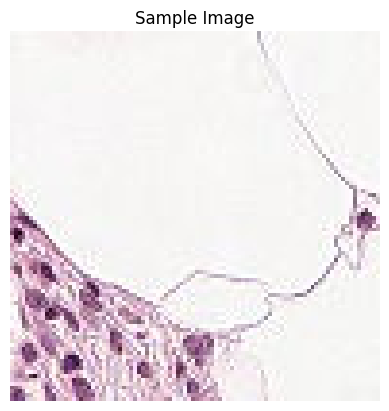

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Visualize one sample
rep=r'/kaggle/input/histopathologic-cancer-detection/train/'
sample=rep+df1['id'].iloc[0]+'.tif'
img = np.array(Image.open(sample))
print(img.shape)

plt.imshow(img)
plt.title('Sample Image')
plt.axis('off')
plt.show()

From the code above, we can tell that each of the train images contains 96x96 pixels and 3 channels. Now that we understand the data structure of the images, assuming that they are all similar, we can start preprocessing the images by converting all of them to arrays and normalizing the values by dividing them by 255.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# process all images and stock them in an array
sizeImg=(img.shape[0],img.shape[1])
listImgs=[]
for i, r in df1.iterrows():
    fichier=rep+r['id']+'.tif'
    listImgs.append(img_to_array(load_img(fichier, target_size=sizeImg))/255.0)
    if i %10000==0 and not i==0:
        print(i,"images have been processed")
    if i>50000:
        break

Now that we have all the graphical data in the form of matrices, we can separate the value of the labels, and then split the data into training set and validation set.

In [ ]:
n=len(listImgs)
y=df1['label'].iloc[:n]
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_tr, X_v,y_tr,y_v = train_test_split(np.array(listImgs),y, test_size=0.2, random_state=42)
print(X_tr.shape,X_v.shape,y_tr.shape,y_v.shape)

Now that we have the data, we can design a deep learning model. Recall that images are represented by huge matrices, so convolutions and pooling must be applied to reduce the features whilst taking into considerations hidden features in the pixels. We will apply the infrastructure taught in class, which is the structure of convolution-convolution-pooling followed by dense layers.

Filter size is set to be 3x3 and output sizes are set to be powers of 2, in a random manner. Activation function is chosent to be reLu for all the convolution layers and max pooling is preferred over average pooling. After convolution and pooling, we flatten the matrices into 1-D arrays before feeding them into the first dense layer to capture complex representations in the images. Finally, we feed the output from the previous dense layer to a dense layer having an output size of 1 and a sigmoid activation function, because this problem is a binary classification problem.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input
from tensorflow.keras.optimizers import RMSprop

model=Sequential()
model.add(Input(shape=(96, 96, 3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer= RMSprop(learning_rate=0.001)
              , loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



After the model is designed, we can now fit the data. Note that we can obtain the learning curve from model.fit, which helps us to understand how the learning is processed and see if there is overfit.

In [ ]:
import time
print(X_tr.shape,X_v.shape,y_tr.shape,y_v.shape)
t1 = time.time()
hist=model.fit(X_tr, y_tr, validation_data=(X_v, y_v), epochs=20, batch_size=32)
dt = time.time()-t1
print(dt,"seconds")

Now we can plot the learning curves for both the training set and the validation set, so that we can choose a reasonable value for "epochs" and avoid overfits.

In [ ]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label = 'val_acc')
plt.title('Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Acc')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(X_v, y_v, verbose=2)
print(val_acc,val_loss)

After the initial success, now we can use keras_tuner to tune our hyperparameters. All filter sizes, output sizes, dropout rates and learning rates can be tuned. This step keeps failing because Kaggle runs out of memory; therefore, I commented some part of the code to make Kaggle work.

In [ ]:
import keras_tuner as kt

def buildModel(hp):
    model=Sequential()
    model.add(Input(shape=(96, 96, 3)))
    model.add(Conv2D(hp.Choice('filter1', [32 #, 64
                                          ]),(3,3),activation='relu'))
    model.add(Conv2D(hp.Choice('filter2', [32 #, 64
                                          ]),(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(hp.Choice('filter3', [128
                                           #, 64
                                          ]),(3,3),activation='relu'))
    model.add(Conv2D(hp.Choice('filter4', [128 #, 64
                                          ]),(3,3),activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer= RMSprop(learning_rate=hp.Choice('lr', [0.001#, 0.01
                                                                   ]))
                  , loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    buildModel,
    objective='val_accuracy',
    max_trials=10
)
tuner.search(
    X_tr, y_tr,
    epochs=10,
    validation_data=(X_v, y_v),
    batch_size=32
)

bestParams=tuner.get_best_hyperparameters(num_trials=1)[0]

print(bestParams.get('filter1'),
      bestParams.get('filter2'),
      bestParams.get('filter3'),
      bestParams.get('filter4'),
      bestParams.get('lr')
     )

After we get our best hyperparameters, we can now train our best model and evaluate it.

In [ ]:
bestM = tuner.hypermodel.build(bestParams)
val_loss, val_acc = bestM.evaluate(X_v, y_v, verbose=2)
print(val_acc,val_loss)

As a conclusion, we obtained our best model. Due to machine performance restriction, I was not able to use the whole dataset but part of it; to improve the performance of the model, we can include more data and perform more detailed hyperparameter tuning.

Now for the submission, we make predictions and output them into a csv file.

In [ ]:
"""df1 = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
rep=r'/kaggle/input/histopathologic-cancer-detection/test/'
listImgs=[]
for i, r in df1.iterrows():
    fichier=rep+r['id']+'.tif'
    listImgs.append(img_to_array(load_img(fichier, target_size=sizeImg))/255.0)

pred=bestM.predict(listImgs)
df2=pd.DataFrame({
    'id': df1['id'], 
    'label': pred.flatten()
})
df2.to_csv('/kaggle/working/pred_output.csv', index=False)

"""